# Preprocess and Repeatability Analysis

In order to exclude the effect of units of different features and measurements, we need to normalize the raw data. We also need to make sure that the measurement of the robot is repeatable so that it is predictable.

## 1. Capture csv files

In [36]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

In [38]:
# Assign file source
folder= '../data/07-09-Data' #TODO: enter the relative directory of the file
mode = 'standing'            #TODO: you can switch between walking and standing
csvfiles = glob.glob(folder+'/'+mode+'/*.csv')
print '{} files in the folder'.format(len(csvfiles))

# Check out csv files
for csvfile in csvfiles:
    print csvfile

8 files in the folder
../data/07-09-Data/standing/2017-07-10T07_19_08.286288.csv
../data/07-09-Data/standing/2017-07-10T07_04_28.092699.csv
../data/07-09-Data/standing/2017-07-10T07_16_41.113935.csv
../data/07-09-Data/standing/2017-07-10T07_06_40.900544.csv
../data/07-09-Data/standing/2017-07-10T07_02_17.650401.csv
../data/07-09-Data/standing/2017-07-10T07_05_32.163705.csv
../data/07-09-Data/standing/2017-07-10T07_13_32.050308.csv
../data/07-09-Data/standing/2017-07-10T07_14_33.837638.csv


## 2. Normalize the data

Normalize the data by zeroing the mean and dividing each feature by its standard deviation.

$$x_i = \frac{x_i - mean(x)}{std(x)}$$

In [44]:
def normalize(csvfiles):
    fields = ['time', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'f1', 't1', 'f2', 't2', 'f3', 't3', 'f4', 't4']
    data_dict = {}
    for i, csvfile in enumerate(csvfiles):
        df = pd.read_csv(csvfile,skiprows=[0],delim_whitespace=True, header=None)
        df.columns = fields
        df['time'] = -df['time'] # Reverse negative sign of time
        for j in xrange(6):      # The first 6 columns are IMU measurements
            field = fields[j+1]
            # Normalization
            df[field] = signal.medfilt(df[field],15)    # reduce noise
            df[field] = df[field] - np.mean(df[field][30:-30]) # normalize
            df[field] /= np.std(df[field][30:-30])
            # store data
            data_dict[csvfile.split('.csv')[0].split('/')[-1]] = df
    return data_dict

In [46]:
# Execute normalize function
data_dict = normalize(csvfiles)

## 3. Plot normalized data

In [47]:
def make_plot(data_dict, output_img=None):
    fig, ax = plt.subplots(2,3, sharex = True, figsize =(16,8))
    fields = ['time', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'f1', 't1', 'f2', 't2', 'f3', 't3', 'f4', 't4']
    for i, df in enumerate(data_dict.itervalues()):
        for j in xrange(6):
            field = fields[j+1]
            ax[j/3,j%3].plot(df['time'], df[field], label='run{}'.format(i))
            ax[j/3,j%3].set_title(field)
            ax[j/3,j%3].set_xlabel('time')
    
    ax[1,2].set_ylim([-2.5,2.5]) # NOTE: z acceleration has very large outliers
    if output_img is not None:
        plt.savefig(output_img)
    plt.show()

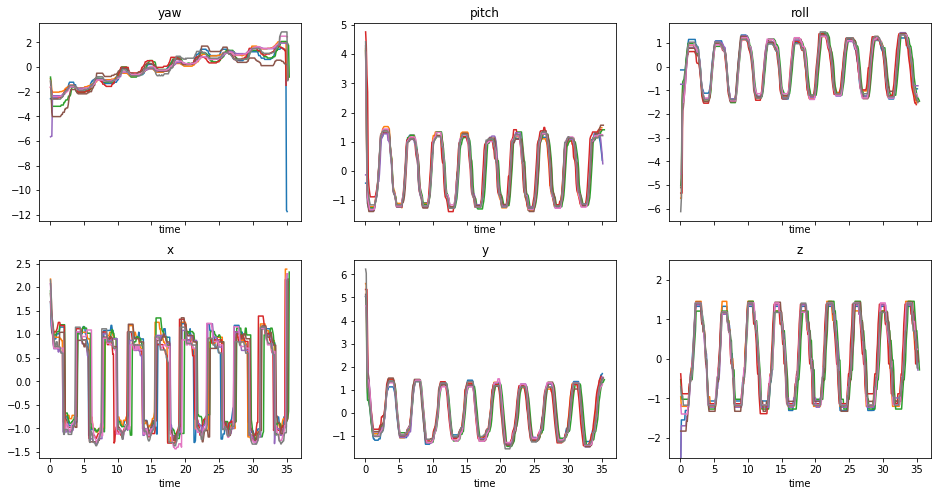

In [48]:
# Execute plot function
make_plot(data_dict)

## 4. Evaluation Metric: Correlation

Quantitative evaluation of repeatibility.

In [49]:
def to_list(data_dict):
    '''
    Transform key of dictionary from csv filename to column name
    '''
    fields = ['time', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'f1', 't1', 'f2', 't2', 'f3', 't3', 'f4', 't4']
    data_list = {f:[] for f in fields}
    for dataframe in data_dict.itervalues():
        for field in fields:
            data_list[field].append(dataframe[field])
    return data_list

def eval_corr(data_list):
    fields = ['time', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'f1', 't1', 'f2', 't2', 'f3', 't3', 'f4', 't4']
    for i in xrange(1,7):
        field = fields[i]
        cor = np.corrcoef(data_list[field])  # correlation matrix
        avg = (np.sum(cor)-len(cor) ) / (len(cor)**2-len(cor))
        std = np.std(data_list[field])
        print 'fieldname: ', field
        print 'average correlation: ', avg
        print 'standard deviation', std
        print

In [50]:
# Execute correlation analysis
data_list = to_list(data_dict)
eval_corr(data_list)

fieldname:  yaw
average correlation:  0.874601996122
standard deviation 1.29862559032

fieldname:  pitch
average correlation:  0.966413259503
standard deviation 1.04219790862

fieldname:  roll
average correlation:  0.958228351468
standard deviation 1.05467864633

fieldname:  x
average correlation:  0.820910098713
standard deviation 1.0096687944

fieldname:  y
average correlation:  0.984641337876
standard deviation 1.08434398903

fieldname:  z
average correlation:  0.984010165704
standard deviation 1.01398170071



## 5. Export normalized data

In [51]:
def export(data_dict, prefix='', postfix='_normalized'):
    for filename, dataframe in data_dict.iteritems():
        output = filename
        output = prefix + output + postfix + '.csv'
        print output
        dataframe.to_csv(output, index=False)

In [52]:
# Execute export function
export(data_dict, prefix='../data/07-09-Data/')

../data/07-09-Data/2017-07-10T07_14_33.837638_normalized.csv
../data/07-09-Data/2017-07-10T07_02_17.650401_normalized.csv
../data/07-09-Data/2017-07-10T07_05_32.163705_normalized.csv
../data/07-09-Data/2017-07-10T07_19_08.286288_normalized.csv
../data/07-09-Data/2017-07-10T07_13_32.050308_normalized.csv
../data/07-09-Data/2017-07-10T07_06_40.900544_normalized.csv
../data/07-09-Data/2017-07-10T07_16_41.113935_normalized.csv
../data/07-09-Data/2017-07-10T07_04_28.092699_normalized.csv


# Presentation Slides

## Team Spyndra
#### July 12, 2017

 * Replaced the servo hat and calibrate the hardware
 * Collected standing and walking data off the cords

### Standing
#### Normalized
<img src="images/standing_normalized.jpg" />

### Standing
#### Unormalized
<img src="images/standing_unormalized.jpg" />

### Standing statistics
<table style="width:30%">
  <tr>
    <th>standing</th>
    <th>Correlation</th>
    <th>STD</th>
  </tr>
  <tr>
    <th>yaw</th>
    <td>0.8746</td>
    <td>1.3201</td>
  </tr>
  <tr>
    <th>pitch</th>
    <td>0.9664</td>
    <td>1.6955</td>
  </tr>
  <tr>
    <th>roll</th>
    <td>0.9582</td>
    <td>1.0643</td>
  </tr>
  <tr>
    <th>x</th>
    <td>0.8209</td>
    <td>0.2881</td>
  </tr>
  <tr>
    <th>y</th>
    <td>0.9846</td>
    <td>0.1849</td>
  </tr>
  <tr>
    <th>z</th>
    <td>0.984</td>
    <td>0.042</td>
  </tr>
</table>

### Walking
#### Unormalized
<img src="images/walking_unormalized.jpg" />

### Walking
#### Normalized
<img src="images/walking_normalized.jpg" />

### Walking Statistics
<table style="width:30%">
  <tr>
    <th>walking</th>
    <th>Correlation</th>
    <th>STD</th>
  </tr>
  <tr>
    <th>yaw</th>
    <td>0.3896</td>
    <td>6.5146</td>
  </tr>
  <tr>
    <th>pitch</th>
    <td>0.9263</td>
    <td>3.6387</td>
  </tr>
  <tr>
    <th>roll</th>
    <td>0.8124</td>
    <td>1.9879</td>
  </tr>
  <tr>
    <th>x</th>
    <td>0.8063</td>
    <td>0.7994</td>
  </tr>
  <tr>
    <th>y</th>
    <td>0.8403</td>
    <td>0.3191</td>
  </tr>
  <tr>
    <th>z</th>
    <td>0.5062</td>
    <td>11.4575</td>
  </tr>
</table>